## Imports

In [1]:
import helper_functions
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import spacy
import numpy as np

/Users/kushagrakesarwani/Documents/Emotion Detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
DIR= 'kaggle/input/emotion-dataset-for-nlp/'
TRAIN_FILE = 'train.txt'
VAL_FILE = 'val.txt'
TEST_FILE = 'test.txt'

In [3]:
train_df = pd.read_csv(DIR+TRAIN_FILE, delimiter=';', header=None, names=['text', 'label'])
val_df = pd.read_csv(DIR+VAL_FILE, delimiter=';', header=None, names=['text', 'label'])
test_df = pd.read_csv(DIR+TEST_FILE, delimiter=';', header=None, names=['text', 'label'])

In [4]:
encoder= LabelEncoder()

## Preprocessing

In [5]:
def preprocess_text(df: pd.DataFrame, emotions: str=['love', 'surprise']):
    """
    Preprocesses text data in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing 'sentence' and 'label' columns.
        emotions (list): List of emotions to drop from the DataFrame.

    Returns:
        pd.DataFrame: DataFrame with preprocessed text and encoded labels.
        TextVectorization: Adapted text vectorization layer.
        LabelEncoder: Label encoder for the labels.
    """
    for i in emotions:
        df = df[df['label'] != i]

    nlp = spacy.load("en_core_web_sm")
    df['processed_text'] = df['text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x) if not token.is_stop and not token.is_punct and not token.is_space]))

    df['label_num'] = encoder.fit_transform(df['label'])
    df.drop(columns=['text', 'label'], inplace=True)
    return df

In [6]:
train_df= preprocess_text(train_df)
val_df= preprocess_text(val_df)

## Visualisation

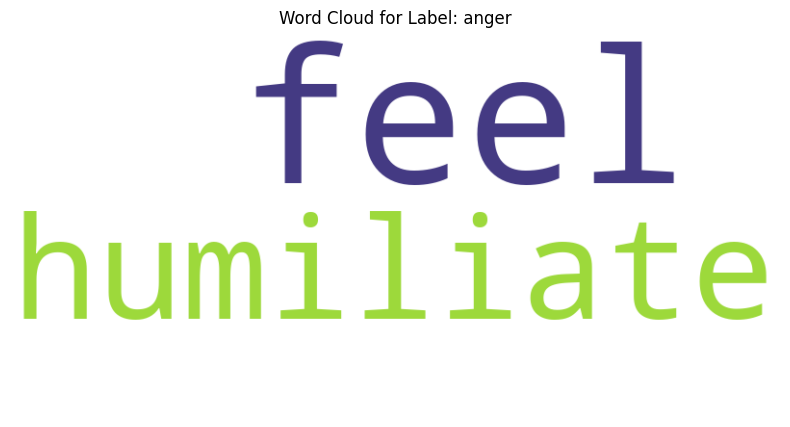

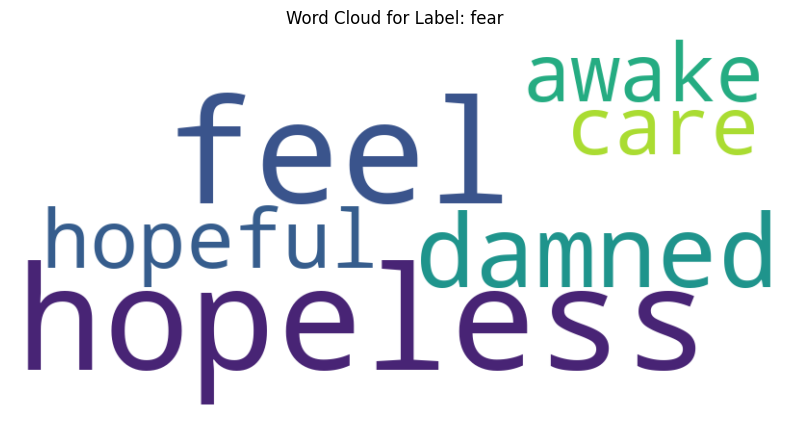

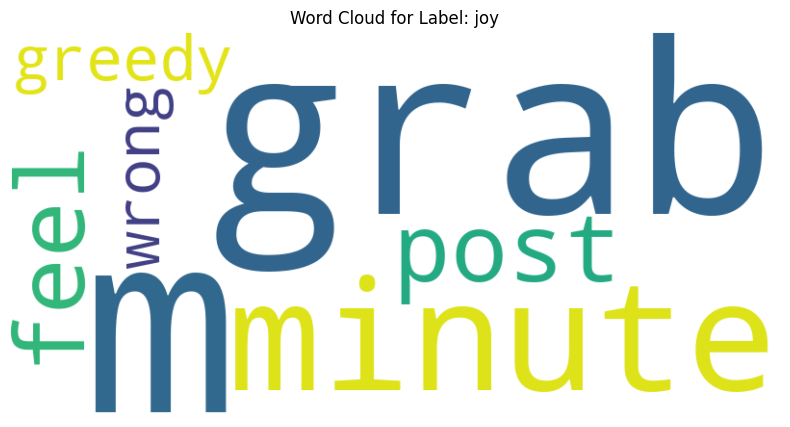

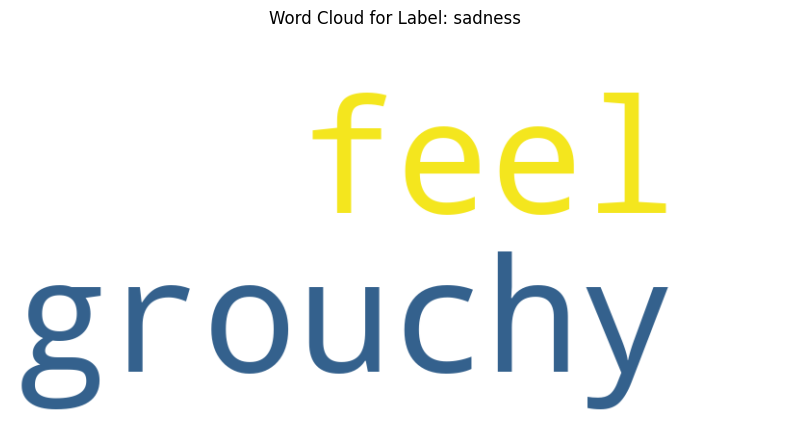

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

label= encoder.classes_

# Generate and plot word cloud for each label
for class_label, text in zip(label, train_df['processed_text']):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {class_label}')
    plt.axis('off')
    plt.show()


## Model

In [8]:
VOCAB_SIZE= 15000
text_vect_layer= tf.keras.layers.TextVectorization(max_tokens= VOCAB_SIZE)
text_vect_layer.adapt(train_df['processed_text'])

In [9]:
from tensorflow.keras import layers

EMBEDDING_UNITS= 64
UNITS= 64
DROPOUT= 0.2

model_v1= tf.keras.Sequential([
    text_vect_layer,
    layers.Embedding(input_dim=text_vect_layer.vocabulary_size(), output_dim= EMBEDDING_UNITS, mask_zero= True),
    layers.GRU(UNITS, dropout= DROPOUT, return_sequences= True),
    layers.GRU(UNITS, dropout= DROPOUT),
    layers.Dense(len(encoder.classes_), activation= 'sigmoid')
])

In [10]:
model_v1.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

In [11]:
BATCH_SIZE= 32  
train_set= tf.data.Dataset.from_tensor_slices((train_df['processed_text'].values, train_df['label_num'].values)).batch(BATCH_SIZE)
val_set= tf.data.Dataset.from_tensor_slices((val_df['processed_text'].values, val_df['label_num'].values)).batch(BATCH_SIZE)

In [12]:
history= model_v1.fit(train_set, validation_data= val_set, epochs= 5)

Epoch 1/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5600 - loss: 1.0019 - val_accuracy: 0.9351 - val_loss: 0.1855
Epoch 2/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9495 - loss: 0.1502 - val_accuracy: 0.9460 - val_loss: 0.1543
Epoch 3/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9761 - loss: 0.0710 - val_accuracy: 0.9414 - val_loss: 0.1861
Epoch 4/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9839 - loss: 0.0482 - val_accuracy: 0.9426 - val_loss: 0.1962
Epoch 5/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9836 - loss: 0.0421 - val_accuracy: 0.9391 - val_loss: 0.2044


In [13]:
eval= model_v1.evaluate(val_set)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9475 - loss: 0.1857


In [14]:
file_path= 'SentimentAnalysis/models/gru_model.keras'
model_v1.save(file_path)

In [15]:
reconstructed_model= tf.keras.models.load_model(f'{file_path}')

## Predictions for a single sentence
To make predictions on a single sentence, we need to do the following steps:
1. Process it in the same manner to remove the extra token words such (as punctuations)
2. Expand the dimension.
3. Pass through the model.

In [16]:
def preprocess_single_sentence(sentence):
    """
    Preprocesses a single sentence.

    Args:
        sentence (str): Input sentence.

    Returns:
        str: Preprocessed and tokenized sentence.
    """
    nlp = spacy.load("en_core_web_sm")
    processed_text = ' '.join([token.lemma_ for token in nlp(sentence) if not token.is_stop and not token.is_punct and not token.is_space])
    return processed_text

In [17]:
sample_text= test_df['text'][8]
true_label= test_df['label'][8]
processed_text= preprocess_single_sentence(sample_text)
sample_text, processed_text

('i like to have the same breathless feeling as a reader eager to see what will happen next',
 'like breathless feeling reader eager happen')

In [18]:
tokenized_sentence= tf.expand_dims(sample_text, 0)

In [19]:
prob= reconstructed_model.predict(tokenized_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


In [20]:
label= prob.argmax()
label

2

In [21]:
counter= encoder.inverse_transform([label])
pred_label= counter[0]

In [22]:
print(f'Predicted Label: {pred_label}')
print(f'True Label: {true_label}')

Predicted Label: joy
True Label: joy


In [ ]:
from keras.models import load_model
import gradio as gr
def make_predictions(text):
    """
    Make predictions on the given text using the trained model.

    Args:
        text (str): The text to make predictions on.

    Returns:
        list: A list of predictions.
    """
    # Load the trained model
    model = load_model('SentimentAnalysis/models/gru_model.keras')
    # Preprocess the text
    text= preprocess_single_sentence(text)
    text= tf.expand_dims(text, 0)
    # Make predictions
    probability = model.predict(text)
    label= probability.argmax()
    pred_label=encoder.inverse_transform([label])
    return pred_label[0]

input= gr.Textbox(lines=5, label="Enter text", placeholder=f"{test_df['text'][2]}")
output= gr.Textbox(label="Predicted Emotion", placeholder=f"{test_df['label'][2]}")

demo= gr.Interface(fn=make_predictions, 
                   inputs=input, 
                   outputs=output, 
                   title='Sentiment Analysis', 
                   description="Predict the emotion in a sentence"
                  )
demo.launch()

/Users/kushagrakesarwani/Documents/Emotion Detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
